<a href="https://colab.research.google.com/github/jplavorr/Data-Science/blob/main/Fraudes_em_Cart%C3%B5es_de_Cr%C3%A9dito.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img alt="Colaboratory logo" width="15%" src="https://i.postimg.cc/zXN3DHM3/Captura-de-tela-2021-04-22-145652.png">

#### **Data Science & Machine Learning**
*by [João Pedro Lavor](https://www.linkedin.com/in/jo%C3%A3o-pedro-lavor-65162312b/)*  

---

# Detecção de Fraudes em Cartões de Crédito

Neste projeto, iremos abordar o problema das fraudes em cartões de crédito, uma das principais preocupações das instituições financeiras como bancos e [fintechs](https://blog.nubank.com.br/fintech-o-que-e/). O aumento das compras no comércio eletrônico durante o isolamento social fez disparar as fraudes envolvendo cartão de crédito. Em apenas 12 meses, quase 9 milhões de brasileiros foram vítimas desse tipo de fraude o que exige mais cuidado e atenção dos usuários consumidores.


<p align=center>
<img src="https://images.unsplash.com/photo-1537724326059-2ea20251b9c8?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=755&q=80" width="80%"></p>

Dentra essas fraudes, aquelas envolvendo cartões de crédito são de grande relevância uma vez que a sua não-detecção acaretará em prejuízos consideráveis, tanto para o consumidor quanto para a instituição financeira.

Um outro fator a ser considerado é a quantidade de falsos positivos, ou seja, aquelas vezes em que você tentou fazer uma compra e teve seu cartão bloqueado preventivamente - o que provavelmente gerou estresse e constrangimento.

Por todos esses motivos, o investimento na área de detecção de fraudes por meio de Inteligência Artificial vem crescendo a cada ano, representando uma grande oportunidade em *Data Science*. 

Dispondo de grandes volumes de dados como base histórica, um algoritmo de machine learning apenas um pouco melhor que os anteriores já representa uma economia de milhões de Reais. E esse é o desafio, aprimorar cada vez mais o uso de algoritmos visando inibir ou evitar transações fraudulentas.

## Importando os Dados

Os dados que usaremos neste projeto foram disponibilizados por algumas empresas européias de cartão de crédito. O *dataset* representa as operações financeiras que aconteceram no período de dois dias, onde foram classificadas 492 fraudes em meio a quase 290 mil transações.

Como você pode notar, este é um conjunto de dados extremamente desbalanceado, onde as fraudes representam apenas 0,17% do total.

Outro detalhe interessante é que as *features* são todas numéricas, e foram descaracterizadas (por problemas ligados à privacidade e segurança). Assim, os nomes das colunas são representados por $[V1, V2, V3 \dots, V28]$ 

<p align=center>
<img src="https://images.unsplash.com/photo-1539622287262-61e066a2c534?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=334&q=80" width="40%"></p>

[Na página original dos dados](https://www.kaggle.com/mlg-ulb/creditcardfraud), também é informado que as variáveis passaram por uma transformação conhecida como Análise de Componentes Principais (*Principal Component Analysis* - PCA).

A [PCA](https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html) permite a redução da dimensionalidade enquanto mantém o maior número possível de informações. Para conseguir isso, o algoritmo encontra um conjunto novo de recursos - os chamados **componentes**.

In [65]:
# instalar a biblioteca scikit-plot
!pip install -q scikit-plot
#@title
# suprimir os warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)


In [34]:
# importar os pacotes necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn.metrics import confusion_matrix

from imblearn.under_sampling import RandomUnderSampler

# configurar o estilo dos gráficos com o Seaborn
sns.set_style('dark')
%matplotlib inline

In [3]:
#Importando o DataSet
file_path = "https://www.dropbox.com/s/b44o3t3ehmnx2b7/creditcard.csv?dl=1"

# importar os dados para um dataframe
df=pd.read_csv(file_path)

## Análise Exploratória 

Com o nosso dataset em mãos, iremos começar a analisar nossos dados para prepar o nosso modelo de machine learning.

In [4]:
#Mostrando primeiras entradas do DataFrame
df.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Apenas olhando as cinco primeiras entradas é possível tirar algumas conclusões:

* As 5 primeiras entradas nos dão uma visão de como a transformação PCA deixou as *features* descaracterizadas (anônimas) e em valores numéricos. Para saber mais sobre PCA, [clique neste *link*](http://www2.ic.uff.br/~aconci/PCA-ACP.pdf).

* As colunas `Time` e `Amount` foram preservadas, mantendo seu valor original.
    * **Time:** Tempo passado a partir do inicio da observação (Segundos); 
    * **Amount:** Valor da transferência;

* A variável alvo (Que iremos prever) está representada na coluna `Class`, onde:
    * **0:** Transação normal; 
    * **1:** Transação fraudulenta;

Vamos olhar agora o resumo estatístico, usando o método `describe()`.

### Distribuição Estatística

In [5]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Podemos confirmar que as variáveis relativas aos componentes principais (transformação PCA) não têm nenhuma discrepância aparente, bem como a coluna `Time`.

Em relação à variável `Amount`, nota-se que o valor médio de transações (considerando ambas as classes) é €88.34, mediana igual a €22.00 e desvio padrão de €250.12. Atingindo o valor máximo de €25691.16, e podemos ver que 75% das transações são valores abaixo de €77.165 o que indica que a maioria das transações são quantias pequenas - como esperado.

### Dados Nulos



In [6]:
#Verificando dados ausentes.
df.isnull().sum().max()

0

Quanto à qualidade do *dataset*, este não apresentou nenhum valor ausente ou que demandasse uma etapa de limpeza. Na função acima, perceba que o maior valor (por coluna) para valores nulos é zero, o que confirma que não há valores ausentes.

### Proporção entre as transações

0    284315
1       492
Name: Class, dtype: int64

Porcentagem de transações fraudulentas do DataSet: 0.1727% 


[]

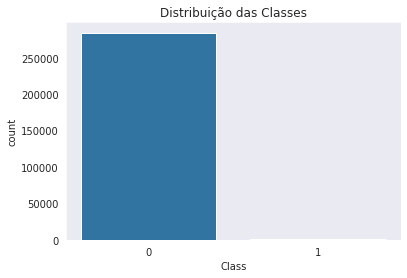

In [7]:
#Número de transações
print(df['Class'].value_counts())
#Porcentagem de transações fraudulentas
print("\nPorcentagem de transações fraudulentas do DataSet: {:.4f}% ".format((df[df.Class == 1].shape[0] / df.shape[0]) * 100))

fig, ax = plt.subplots()
sns.countplot(x="Class", data=df, ax=ax)
ax.set_title('Distribuição das Classes')
plt.plot()


Como é [informado na descrição dos dados](https://www.kaggle.com/mlg-ulb/creditcardfraud), as entradas relativas à transações fraudulentas correspondem a 0,17% do total.

O gráfico de barras mostra como essa discrepância se torna nítida e visível. Na prática, isso interfere no desempenho do modelo, e será necessário fazer um balanceamento dos dados antes de alimentar o modelo final de classificação.

Agora vamos procurar análisar se existe alguma relação entre as transações e as variáveis `time` e `amount`.

#### Relação entre `Time` e `Class`

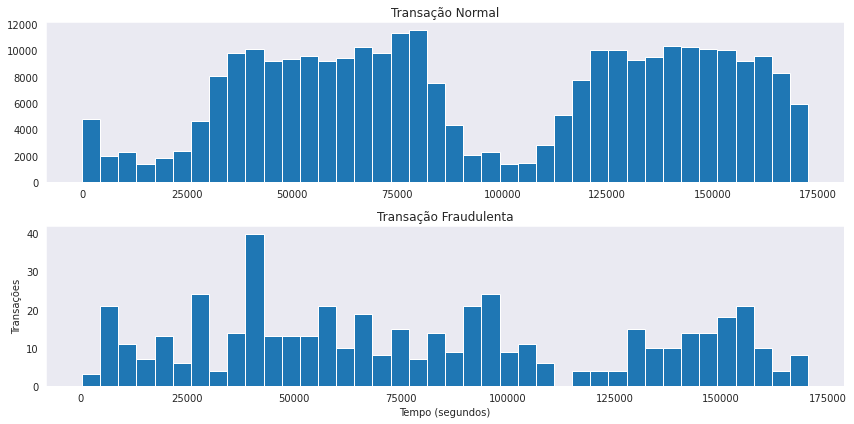

In [8]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,6))
n_bins = 40

ax[0].hist(df.Time[df.Class==0], bins=n_bins)
ax[0].set_title('Transação Normal')
ax[1].hist(df.Time[df.Class==1], bins=n_bins)
ax[1].set_title('Transação Fraudulenta')

plt.xlabel('Tempo (segundos)')
plt.ylabel('Transações')
plt.tight_layout()


Utilizando os Histogramas para comparar as distribuições das 2 classes ao longo da dimensão tempo (`Time`). No entanto, não foi identificada nenhum informação a partir das distribuições de frequência acima.

#### Relação entre `Amount` e `Class`

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


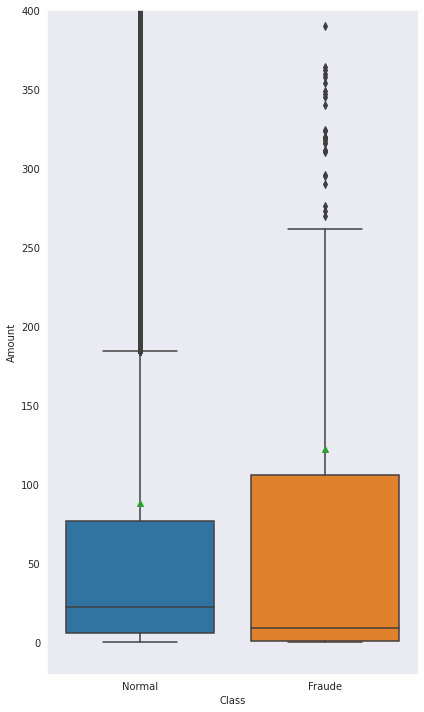

In [9]:
fig, ax = plt.subplots(figsize=(6,10), sharex=True)
sns.boxplot(df.Class, df.Amount, showmeans=True, ax=ax)
plt.ylim((-20, 400))
plt.xticks([0, 1], ['Normal', 'Fraude'])

plt.tight_layout()

Plotou-se os *boxplots* para ver se há alguma diferença no padrão transações em relação à dimensão `Amount`.

De uma maneira geral, percebe-se uma distribuição diferente para as duas classes, o que provavelmente irá contribuir para o treinamento do modelo de *machine learning*.


Vamos procurar entender dentre o nosso conjunto de variáveis o comportamento de sua distribuição para procurar analisar quais aparentam serem as mais importantes na detecção de anomalias e para isso, o gráfico de densidade é muito útil.

#### Gráfico de Densidade

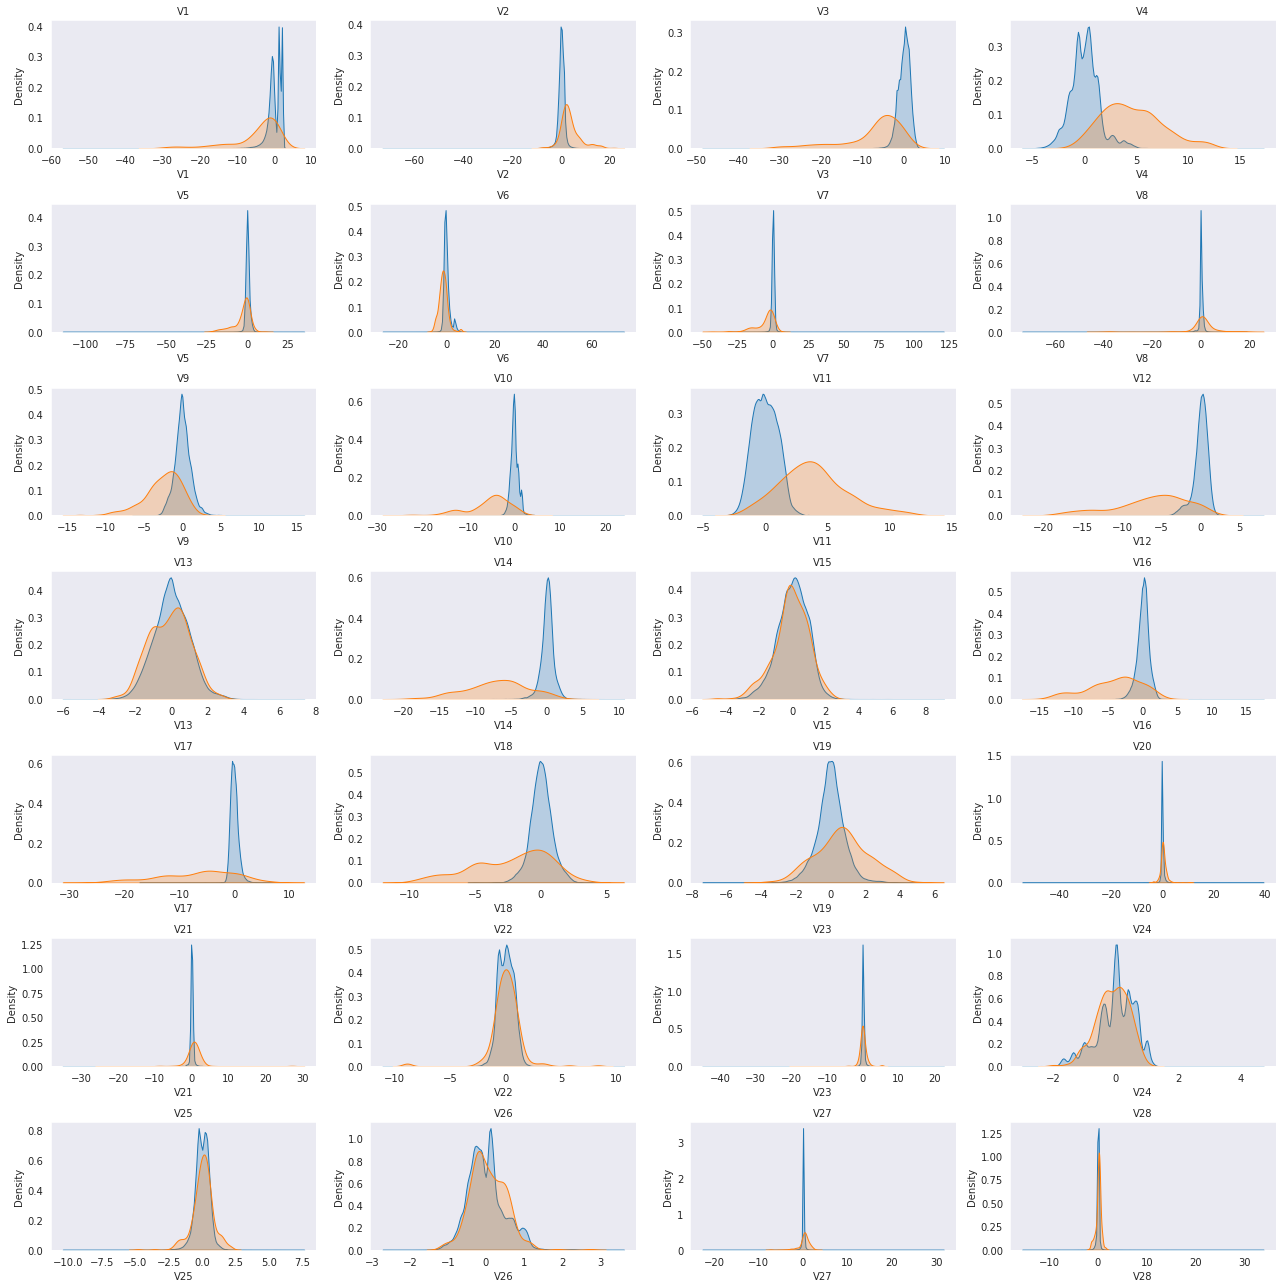

In [17]:
column_names = df.drop(['Class', 'Amount', 'Time'], axis=1).columns
num_plots = len(column_names)
df_class_0 = df[df.Class == 0]
df_class_1 = df[df.Class == 1]

fig, ax = plt.subplots(nrows=7, ncols=4, figsize=(18,18))
fig.subplots_adjust(hspace=1, wspace=1)

idx = 0
for col in column_names:
    idx += 1
    plt.subplot(7, 4, idx)
    sns.kdeplot(df_class_0[col], label="Class 0", shade=True)
    sns.kdeplot(df_class_1[col], label="Class 1", shade=True)
    plt.title(col, fontsize=10)
plt.tight_layout()

O que se procura nesse tipo de visualização são distribuições que diferem uma da outra, permitindo identificar fraudes mais facilmente. Veja como exemplo as variáveis `V3`, `V4`, `V10` e `V11`, como elas são bem distintas.

Por outro lado, variáveis como `V8`, `V13` e `V15` são muito similares, apresentando aproximadamente o mesmo comportamento.

###Conclusão da Análise Exploratória.

Resumidamente, algumas observações principais que puderam ser extraídas dessa etapa exploratória foram:

* O *dataset* está muito desbalanceado, uma vez que as transações fraudulentas representam apenas 0,17% das entradas totais.
* Não existem valores ausentes ou nulos no *dataframe*.
* Uma vez que a PCA é sensível à escala das variáveis, assume-se a premissa que as *features* originais foram padronizadas.
* As colunas `Time` e `Amount` não estão normalizadas.

# Montando Modelo de Previsão Desbalanceado.

Como dito anteriormente, os dados estão desbalanceados, com as transações fraudulentas representando apenas 0,17% da entrada `Class`. 
Vamos montar um modelo de previsão para esse conjunto e entender o quão bem o modelo consegue prever com os dados desbalanceados.

Como temos um problema de classificação, iremos alimentar esses dados em um modelo de Regressão Logística que iremos ocnstruir. Para preparar esse modelo, iremos fazer:

* Padronizar as *features* `Time` e `Amount`, que estão em outra ordem de grandeza.
* Dividir entre dados de treino e teste

**Padronizar `Time` e `Amount`**

Para esta etapa, uma vez que a coluna `Amount` possui *outliers* será usada a padronização por meio da classe `StandardScaler`.

In [45]:
df_clean = df.copy()
std_scaler = StandardScaler()
df_clean['std_amount'] = std_scaler.fit_transform(df_clean['Amount'].values.reshape(-1, 1))
df_clean['std_time'] = std_scaler.fit_transform(df_clean['Time'].values.reshape(-1, 1))
df_clean.drop(['Amount', 'Time'], axis=1, inplace = True)

df_clean.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,std_amount,std_time
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964,-1.996583
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475,-1.996583
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686,-1.996562
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534,-1.996562
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403,-1.996541


## Preparando dados de treino
Vamos separar nossas variáveis e dividi-las entre variáveis de treino e variavéis de teste.

Mesmo antes de proceder com o balanceamento de dados, devemos splitar os dados já existentes entre treino e teste. Caso contrário, não teremos parâmetros para conferir se o balanceamento foi adequado. Como não iremos fazer o balanceamento nessa etapa, iremos apenas seguir com nossas variáveis de treino e teste.

Para garantir que os conjuntos de treino e teste tenham a mesma quantidade de classes proporcionalmente, passamos `stratify=True`.

In [46]:
#Separando as variáveis
X = df_clean.drop('Class', axis = 1)
y = df_clean['Class']

#Dividir entre treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, shuffle = True)

## Modelo de Machine Learning Desbalanceado

Com todos os dados separados e após uma análise exploratória completa, irei construir um classificador usando a Regressão Logística.

Após instanciar o modelo, o mesmo será treinado em cima dos dados em `X_train` e `y_train`. Na sequência, serão realizadas as previsões sobre os dados de teste.

In [54]:
# instanciar e treinar um modelo de Regressão Logística
np.random.seed(2)
model = LogisticRegression()
model.fit(X_train, y_train)

# fazer as previsões em cima dos dados de teste
y_pred_desbalanceado = model.predict(X_test)
y_proba_desbalanceado = model.predict_proba(X_test)

Com o modelo treinado e as previsões feitas, parte-se para a avaliação do desempenho.

Neste tipo de problema desbalanceado, a acurácia não é uma métrica adequada e vamos entender o motivo após plotarmos nossa matriz de confusão.

Observe a matriz de confusão para ver a taxa de acertos para transações fraudulentes, ou pela coluna *recall* do Relatório de Classificação. 
##Avaliação de Desempenho

In [55]:
# imprimir relatório de classificação
print("Relatório de Classificação:\n", classification_report(y_test, y_pred_desbalanceado, digits=4))

# imprimir a acurácia do modelo
print("Acurácia: {:.4f}\n".format(accuracy_score(y_test, y_pred_desbalanceado)))

# imprimir a área sob da curva
print("AUC: {:.4f}\n".format(roc_auc_score(y_test, y_pred_desbalanceado)))

Relatório de Classificação:
               precision    recall  f1-score   support

           0     0.9995    0.9999    0.9997     71079
           1     0.9271    0.7236    0.8128       123

    accuracy                         0.9994     71202
   macro avg     0.9633    0.8617    0.9062     71202
weighted avg     0.9994    0.9994    0.9994     71202

Acurácia: 0.9994

AUC: 0.8617



Nesse relatório, vemos que a acurácia do modelo é de 99,94%, o que pode aparecer algo fantástico, mas o que dizer daquele fator que mais importava para nós, a capacidade de detectar fraudes no cartão de crédito?

Uma outra métrica considerada interessante para se avaliar a eficácia é a [AUC ROC](https://medium.com/bio-data-blog/entenda-o-que-%C3%A9-auc-e-roc-nos-modelos-de-machine-learning-8191fb4df772), ou área sob a curva. No caso desse modelo de Regressão Logística, tem-se 86,17% de AUC.

Por causa do desbalanceamento de dados, o modelo foi capaz de classificar bem as instâncias onde df.Class == 0 (transações normais), mas acertou menos de 75% dos casos em que df.Class == 1.

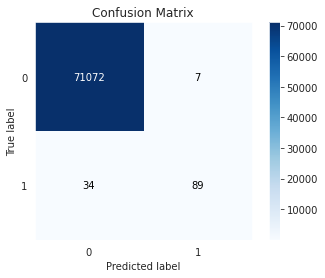

In [56]:
# plotar a matrix de confusão
skplt.metrics.plot_confusion_matrix(y_test, y_pred_desbalanceado)


Vimos anteriormente uma acurácia de 99,94%, mas olhando a matriz de confusão, nosso modelo conseguiu prever apenas 89 transações fraudulentas com precisão, dentre 123 transações fraudulentas. Ele preveu corretamente(Recall) 72,24%  das transações fraudulentas, isso faz com que apareça uma boa quantidade de **Falsos Negativos** (quando temos uma transação fradulenta e o modelo classifica como transação normal), o que não é algo muito interessante para a instituição financeira. 

#Montando modelo de Previsão Balanceado

Como vimos anteriormente, passar despercebido o desbalanceamento dos dados pode acarretar grandes prejuízos as instituições financeiras pela grande quantidade de falsos negativos presentes. seria preferível “errar para mais” e ter uma quantidade maior de **Falsos Positivos** (quando temos uma transação normal e o modelo classifica como transação fraudulenta). Uma situação aonde seu cartão bloqueado preventivamente e teve que ligar no banco para confirmar as últimas compras que havia feito.

## Métodos para lidar com datasets desbalanceados

Há diversas maneiras para atacar o problema de dados desbalanceados, para o nosso problema, iremos a abordagem **sampling**, especificamente, iremos fazer **Under-sampling**, que consiste em reduzir o desbalanceamento do dataset focando na classe majoritária. Ou seja, elimina aleatoriamente entradas da classe com maior número de ocorrências.



##Preparando os Dados
Usando a biblioteca `imblearn` é possível aplicar facilmente técnicas de balanceamento de dados. No caso, a opção neste projeto foi usar *Under-sampling*, preservando a classe minoritária, que é nossa variável alvo.



1    369
0    369
dtype: int64


[]

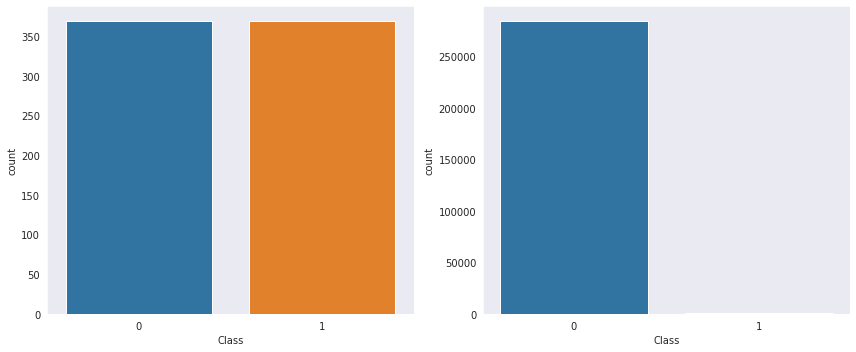

In [73]:
rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_sample(X_train, y_train);

# ver o balanceamento das classes
print(pd.Series(y_rus).value_counts());

# plotar a nova distribuição de classes
fig, ax =  plt.subplots(1, 2, figsize=(12,5))
sns.countplot("Class", data = df, ax=ax[1])
sns.countplot(y_rus, ax=ax[0]);
ax[0].set_xlabel('Class')
plt.tight_layout()
plt.plot()

É fácil ver que não há mais aquela discrepância inicial quando lidamos com os dados desbalanceados (Figura da direita). 

Agora com os dados balanceados, vamos olhar se mudou algo em relação a correlação entre as variáveis, utilizando uma matriz de correlação.

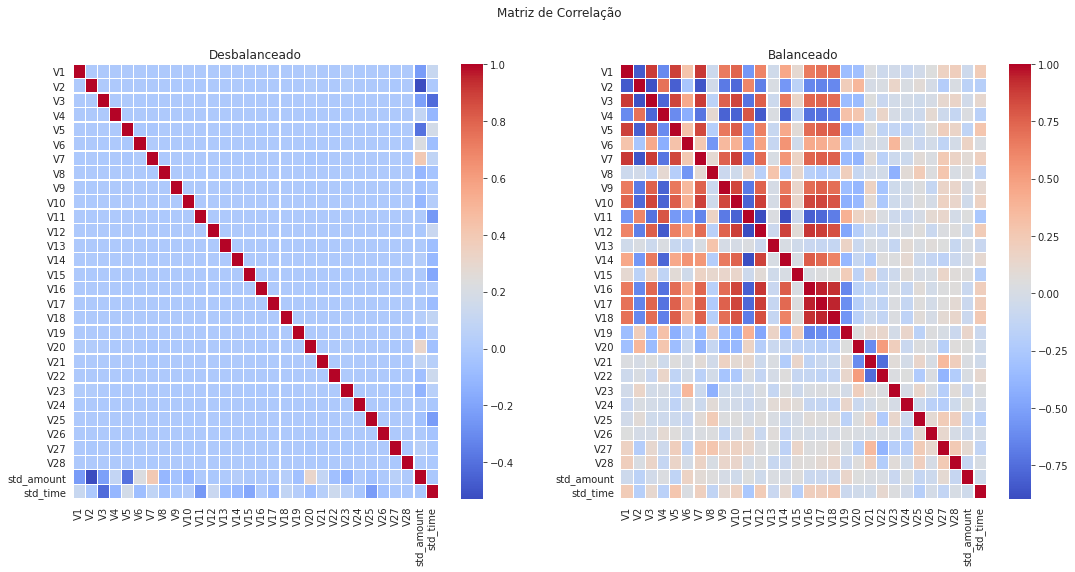

In [67]:
# plotar a matriz de correlação
corr = X_train.corr()
corr_rus = pd.DataFrame(X_rus).corr()


fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (18,8))
fig.suptitle('Matriz de Correlação')

sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns,
            linewidths=.1, cmap="coolwarm", ax=ax[0])
ax[0].set_title('Desbalanceado')

sns.heatmap(corr_rus, xticklabels=corr.columns, yticklabels=corr.columns,
            linewidths=.1, cmap="coolwarm", ax=ax[1])
ax[1].set_title('Balanceado')

plt.show()

Com os dados balanceados, podemos ver a matriz de correlação (da direita) e identificar quais variáveis estão mais fortemente relacionadas com as outras.

Observe como anteriormente, sem o balanceamento de dados, a matriz de correlação não trazia nenhuma informação relevante. Entretanto, ela traz muito mais informações após um correto balanceamento.

## Modelo de Machine Learning Balanceado
Com os dados balanceados, iremos novamente construir nosso modelo de classificação usando Regressão Logística. 

Após instanciar o modelo, o mesmo será treinado em cima dos dados em `X_rus` e `y_rus`. Na sequência, serão realizadas as previsões sobre os dados de teste e iremos comparar como foi o resutlado da previsão.

In [74]:
# instanciar e treinar um modelo de Regressão Logística
np.random.seed(2)
model = LogisticRegression()
model.fit(X_rus, y_rus)

# fazer as previsões em cima dos dados de teste
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)

Com o modelo treinado e as previsões feitas, vamos partir para a avaliação de desempenho.

###Avaliação de Desempenho

Relatório de Classificação:
               precision    recall  f1-score   support

           0     0.9999    0.9659    0.9826     71079
           1     0.0450    0.9268    0.0858       123

    accuracy                         0.9659     71202
   macro avg     0.5224    0.9464    0.5342     71202
weighted avg     0.9982    0.9659    0.9811     71202

Acurácia: 0.9659

AUC: 0.9464



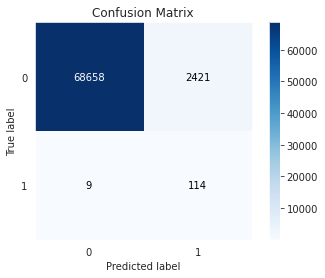

In [44]:
# plotar a matrix de confusão
skplt.metrics.plot_confusion_matrix(y_test, y_pred)

# imprimir relatório de classificação
print("Relatório de Classificação:\n", classification_report(y_test, y_pred, digits=4))

# imprimir a acurácia do modelo
print("Acurácia: {:.4f}\n".format(accuracy_score(y_test, y_pred)))

# imprimir a área sob da curva
print("AUC: {:.4f}\n".format(roc_auc_score(y_test, y_pred)))

<table>
<thead>
<tr> <th> Dados </th> <th>Acurácia</th><th>AUC</th> <th>Recall(Class = 1)</th><th>Proporção de F.N.</th> <th>Proporção de F.P.</th></tr>
</thead>
<tbody>
<tr><td>Desbalanceados</td><td>99,94%</td><td>86,17%</td><td>72,36%</td> <td>27,64%</td> <td>0,01%</td> </tr>
<tr><td>Balanceados</td><td>96,59%</td><td>99,94%</td><td>92,68%</td> <td>7,31%</td> <td>3.4%</td></tr>
</tbody>
</table>


Com ajuste da tabela acima, podemos notar a diferença na classificação dos dois modelos após suas previsões. Podemos notar as seguintes diferenças:

* O modelo Balanceado apresentou uma diminuição muito grande na quantidade de Falsos Negativos.

* Tivemos um aumento na métrica Recall, que representa o quão bem o modelo foi capaz de prever os acertos dentro das fraudes.

* O modelo Balanceado apresenta um aumento na quantidade de Falsos Positivos.

* Podemos ver que a Acurácia do modelo diminuiu com o Balanceamento.

* AUC aumentou com o Balanceamento.

#Conclusão
São diversos os motivos que permitem que os dados sejam desbalanceados. Pode ser que o cientista de dados não conseguiu coletar igualmente dados de cada classe, ou que a amostra de fato reflita a população, desbalanceada.

Independente dos motivos, o não tratamente desse desbalanceamento afetará negativamente o desempenho do modelo, refletindo na qualidade global do seu projeto de Data Science.


Com base no nosso modelo, podemos concluir:

* Com um modelo não balanceado, temos que tomar cuidado com qual método iremos usar para tentar balancear nosso modelo, para poder tirar o melhor proveito do nosso modelo de classificação. Para entender mais sobre dados desbalanceados, recomendo [este artigo](http://sigmoidal.ai/como-lidar-com-dados-desbalanceados/) do Blog Sigmoidal.

* Nesse modelo de classificação, notamos que a *acurácia* não desempenhou como um bom modelo de classificação, uma vez que tivemos a acurácia diminuída após balancearmos nosso DataSet no qual apresentou uma melhor classificação após balanceado.

* A métrica *Recall* se mostrou bastante eficiente, ao mostrar a proporção de acertos do modelo para transações normais e transações fraudulentas, assim nos pudemos enxergar que a acurácia não era uma boa métrica para os dados desbalanceados. 

* O AUC se mostrou uma boa métrica para classificação do modelo, uma vez que ao balanceamos os dados o AUC correspondeu com um aumento na porcentagem.

Com o balanceamento tivemos um aumento nos Falsos Positivos, o que é uma situação chata para o cliente, mas o mesmo tempo, pode ser facilmente resolvida pela instituição financeira.  

